In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import pdb
import os 
import data
import maml
import regressors
from collections import OrderedDict
import copy

from model import *
from utils import *

import time

In [2]:
gen = data.SinusoidGenerator(batch_size = 64,
                 num_tasks = 256,
                 x_range = (-5, 5),
                 A_range = (0.1, 5),
                 P_range = (0, np.pi))

task = gen.generate_task()
task1 = task

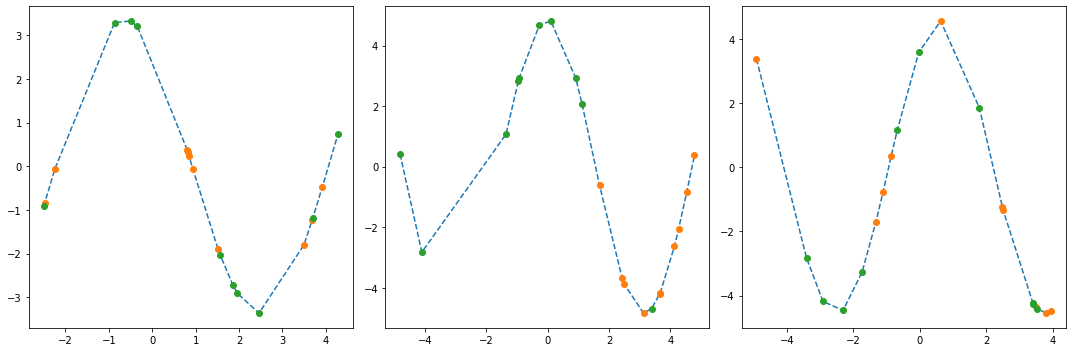

In [3]:
n_rows = 1
n_cols = 3

fig, axes = plt.subplots(n_rows,n_cols,figsize=(5*n_cols,5*n_rows))

for idx, ax in enumerate(axes.flatten()):
    x = task['x'][idx,:,:].cpu()
    y = task['y'][idx,:,:].cpu()
    xc = task['x_context'][idx,:,:].cpu()
    yc = task['y_context'][idx,:,:].cpu()
    xt = task['x_target'][idx,:,:].cpu()
    yt = task['y_target'][idx,:,:].cpu()
    
    ax.plot(x,y,'--')
    ax.plot(xc,yc,'o')
    ax.plot(xt,yt,'o')
    #ax.title.set_text(idx)
    #ax.set_xlim(-5,5)
    plt.tight_layout()

In [39]:
%%capture
#fig, axes = plt.subplots(3,3,figsize=(20,15))
fig = plt.figure(figsize=(15,5))
for idx in range(task['x'].shape[0]):
    xc = task['x_context'][idx,:,:].cpu()
    yc = task['y_context'][idx,:,:].cpu()
    xt = task['x_target'][idx,:,:].cpu()
    yt = task['y_target'][idx,:,:].cpu()
    plt.plot(xc,yc,'o--')
    #ax.title.set_text(idx)
    #ax.set_xlim(-5,5)
    plt.tight_layout()

In [60]:
model = ModelMLPSinusoid().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=.01)
meta_model = maml.MAML_trainer(model, optimizer)
alpha=0.01

In [61]:
def plot_example(task, num_plots, model, epoch):
    
    fig, axes = plt.subplots(1,num_plots, figsize=(20,5))
    
    for idx, ax in enumerate(axes.flatten()):
        
        test_model = copy.deepcopy(model)
        
        x_supports = task['x_context']
        y_supports = task['y_context']

        x_queries = task['x_target']
        y_queries = task['y_target']
            
        updated_params = test_model._inner_loop_train(x_supports[idx], y_supports[idx], alpha)
        
        with torch.no_grad():
            # Collect predictions for query sets, using model updated params for specific task
            
            prior_query_predictions = test_model.regressor(x_queries[idx],OrderedDict(test_model.regressor.named_parameters()))
            prior_query_Loss = F.mse_loss(prior_query_predictions, y_queries[idx])
            
            updated_query_predictions = test_model.regressor(x_queries[idx], updated_params)
            updated_query_loss = F.mse_loss(updated_query_predictions, y_queries[idx])
            
            # Collect predictions for test set
            x_test = torch.unsqueeze(torch.tensor(np.linspace(-5,5), dtype=torch.float32, device=device),1)
            
            prior_predictions = test_model.regressor(x_test,OrderedDict(test_model.regressor.named_parameters()))
            updated_predictions = test_model.regressor(x_test,updated_params)
        
        ax.plot(x_supports[idx].cpu(),y_supports[idx].cpu(), 'o')
        ax.plot(x_queries[idx].cpu(),y_queries[idx].cpu(), 'o')
        
        ax.plot(x_queries[idx].cpu(), prior_query_predictions.cpu(), 'xg')
        ax.plot(x_test.cpu(), prior_predictions.cpu(), '--g')
        
        ax.plot(x_queries[idx].cpu(), updated_query_predictions.cpu(), 'xb')
        ax.plot(x_test.cpu(), updated_predictions.cpu(), '--b')
        
        ax.set_title("Epoch: {}: prior loss {:.4f}: updated loss {:.4f}".format(epoch, prior_query_Loss, updated_query_loss))
    
    plt.show()

Epoch : 0 ¦ Prior loss : 108.03 ¦ Updated loss : 52.69 ¦ Time : 30.95


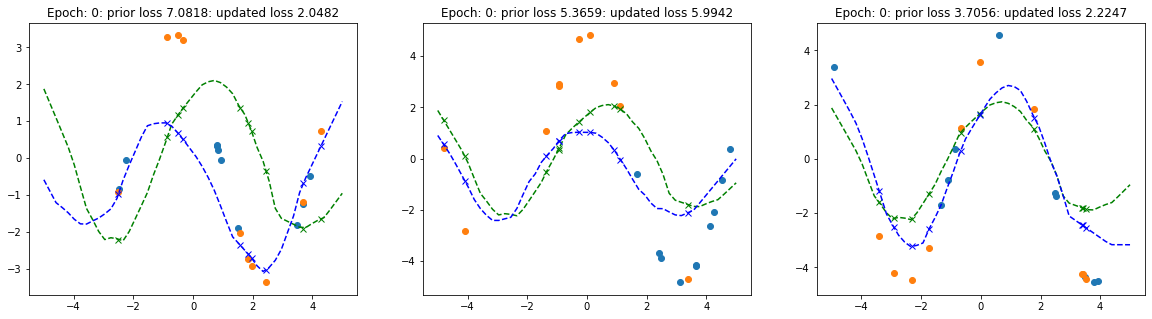

Epoch : 1 ¦ Prior loss : 154.88 ¦ Updated loss : 28.74 ¦ Time : 30.93
Epoch : 2 ¦ Prior loss : 151.07 ¦ Updated loss : 26.31 ¦ Time : 30.66
Epoch : 3 ¦ Prior loss : 135.35 ¦ Updated loss : 21.33 ¦ Time : 30.46
Epoch : 4 ¦ Prior loss : 148.04 ¦ Updated loss : 20.75 ¦ Time : 30.48
Epoch : 5 ¦ Prior loss : 145.41 ¦ Updated loss : 19.87 ¦ Time : 30.84
Epoch : 6 ¦ Prior loss : 146.25 ¦ Updated loss : 19.93 ¦ Time : 30.89
Epoch : 7 ¦ Prior loss : 133.54 ¦ Updated loss : 19.33 ¦ Time : 30.96
Epoch : 8 ¦ Prior loss : 137.53 ¦ Updated loss : 18.55 ¦ Time : 31.01
Epoch : 9 ¦ Prior loss : 136.08 ¦ Updated loss : 18.68 ¦ Time : 30.46
Epoch : 10 ¦ Prior loss : 120.71 ¦ Updated loss : 17.42 ¦ Time : 30.52


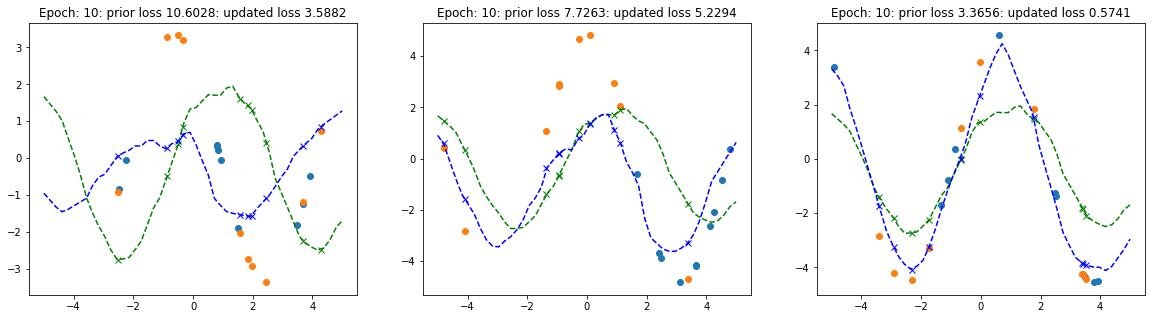

Epoch : 11 ¦ Prior loss : 122.63 ¦ Updated loss : 16.95 ¦ Time : 30.82
Epoch : 12 ¦ Prior loss : 135.01 ¦ Updated loss : 17.66 ¦ Time : 30.74
Epoch : 13 ¦ Prior loss : 149.33 ¦ Updated loss : 19.62 ¦ Time : 30.68
Epoch : 14 ¦ Prior loss : 133.58 ¦ Updated loss : 18.08 ¦ Time : 30.61
Epoch : 15 ¦ Prior loss : 111.72 ¦ Updated loss : 15.36 ¦ Time : 30.29
Epoch : 16 ¦ Prior loss : 115.81 ¦ Updated loss : 15.69 ¦ Time : 30.52
Epoch : 17 ¦ Prior loss : 120.52 ¦ Updated loss : 15.82 ¦ Time : 30.72
Epoch : 18 ¦ Prior loss : 133.68 ¦ Updated loss : 18.27 ¦ Time : 30.72
Epoch : 19 ¦ Prior loss : 138.83 ¦ Updated loss : 18.22 ¦ Time : 30.75
Epoch : 20 ¦ Prior loss : 138.26 ¦ Updated loss : 17.13 ¦ Time : 30.92


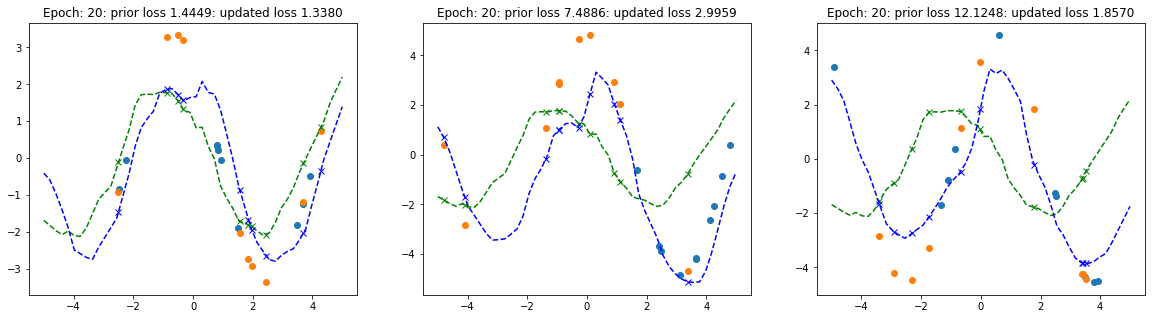

Epoch : 21 ¦ Prior loss : 127.64 ¦ Updated loss : 16.68 ¦ Time : 30.76
Epoch : 22 ¦ Prior loss : 129.40 ¦ Updated loss : 16.53 ¦ Time : 30.47
Epoch : 23 ¦ Prior loss : 145.19 ¦ Updated loss : 18.19 ¦ Time : 30.67
Epoch : 24 ¦ Prior loss : 176.48 ¦ Updated loss : 21.77 ¦ Time : 30.70
Epoch : 25 ¦ Prior loss : 142.39 ¦ Updated loss : 21.69 ¦ Time : 30.64
Epoch : 26 ¦ Prior loss : 170.04 ¦ Updated loss : 21.45 ¦ Time : 30.71
Epoch : 27 ¦ Prior loss : 175.49 ¦ Updated loss : 21.13 ¦ Time : 30.62
Epoch : 28 ¦ Prior loss : 158.95 ¦ Updated loss : 18.89 ¦ Time : 30.25
Epoch : 29 ¦ Prior loss : 145.22 ¦ Updated loss : 18.81 ¦ Time : 30.83
Epoch : 30 ¦ Prior loss : 153.31 ¦ Updated loss : 18.88 ¦ Time : 30.87


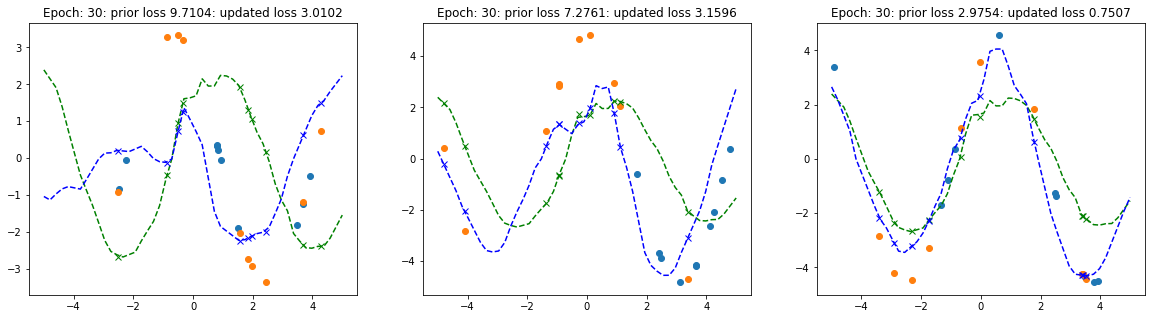

Epoch : 31 ¦ Prior loss : 152.37 ¦ Updated loss : 18.54 ¦ Time : 30.80
Epoch : 32 ¦ Prior loss : 151.95 ¦ Updated loss : 18.37 ¦ Time : 30.86
Epoch : 33 ¦ Prior loss : 146.20 ¦ Updated loss : 18.10 ¦ Time : 30.82
Epoch : 34 ¦ Prior loss : 144.55 ¦ Updated loss : 17.97 ¦ Time : 30.65
Epoch : 35 ¦ Prior loss : 147.34 ¦ Updated loss : 19.92 ¦ Time : 30.53
Epoch : 36 ¦ Prior loss : 151.09 ¦ Updated loss : 21.90 ¦ Time : 30.82
Epoch : 37 ¦ Prior loss : 148.03 ¦ Updated loss : 20.81 ¦ Time : 30.76
Epoch : 38 ¦ Prior loss : 127.72 ¦ Updated loss : 17.02 ¦ Time : 31.25
Epoch : 39 ¦ Prior loss : 151.43 ¦ Updated loss : 19.42 ¦ Time : 30.91
Epoch : 40 ¦ Prior loss : 119.97 ¦ Updated loss : 15.76 ¦ Time : 30.89


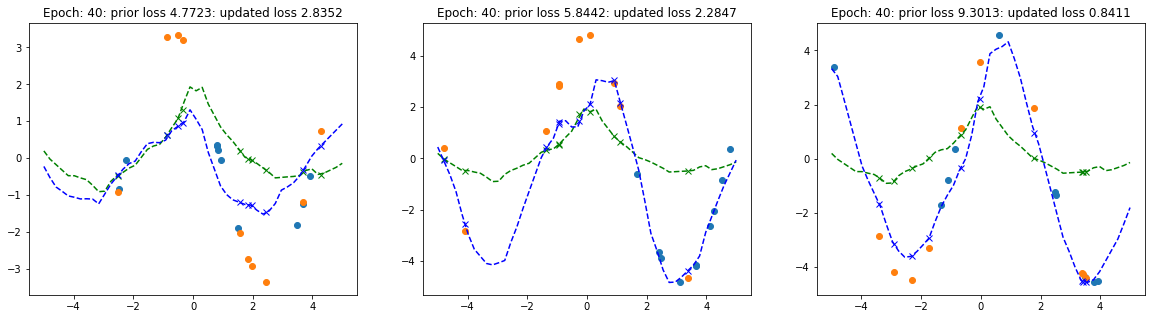

Epoch : 41 ¦ Prior loss : 154.88 ¦ Updated loss : 18.91 ¦ Time : 30.44
Epoch : 42 ¦ Prior loss : 147.93 ¦ Updated loss : 18.61 ¦ Time : 30.67
Epoch : 43 ¦ Prior loss : 151.25 ¦ Updated loss : 19.02 ¦ Time : 30.80
Epoch : 44 ¦ Prior loss : 160.02 ¦ Updated loss : 18.93 ¦ Time : 30.76
Epoch : 45 ¦ Prior loss : 177.52 ¦ Updated loss : 20.82 ¦ Time : 30.74
Epoch : 46 ¦ Prior loss : 151.08 ¦ Updated loss : 18.93 ¦ Time : 30.70
Epoch : 47 ¦ Prior loss : 128.23 ¦ Updated loss : 16.23 ¦ Time : 30.46
Epoch : 48 ¦ Prior loss : 156.94 ¦ Updated loss : 19.15 ¦ Time : 30.45
Epoch : 49 ¦ Prior loss : 160.94 ¦ Updated loss : 19.04 ¦ Time : 30.68


In [62]:
num_epochs = 50
gen.num_tasks = 512
gen.batch_size = 32

losses = []
prior_losses = []
avg_loss = RunningAverage()
avg_prior_loss = RunningAverage()

for epoch in range(num_epochs):
    
    start_time = time.time()
    avg_loss.reset()
    avg_prior_loss.reset()
    
    for idx, task in enumerate(gen):
        
        loss, prior_loss = meta_model.outer_loop_train(task['x_context'],
                          task['y_context'],
                          task['x_target'],
                          task['y_target'])
        
        with torch.no_grad():
            avg_loss.update(loss)
            avg_prior_loss.update(prior_loss)
        
    losses.append(avg_loss.avg)
    prior_losses.append(avg_prior_loss.avg)
    elapsed_time = time.time() - start_time
    print(f"Epoch : {epoch} ¦ Prior loss : {float(avg_prior_loss.avg):.2f} ¦ Updated loss : {float(avg_loss.avg):.2f} ¦ Time : {elapsed_time:.2f}")

    if (epoch % 10) == 0:
        num_plots = 3
        plot_example(task1, num_plots, meta_model, epoch)

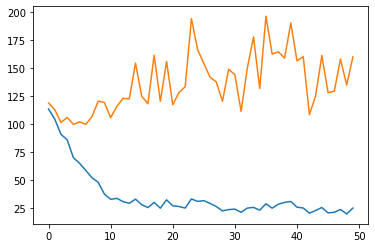

In [59]:
plt.plot(losses)
plt.plot(prior_losses)
plt.show()

In [ ]:
def test(task, idx, model, optimizer, epoch):
    
    xc = task['x_context'][idx,:,:]
    yc = task['y_context'][idx,:,:]
    xt = task['x_target'][idx,:,:]
    yt = task['y_target'][idx,:,:]
    
    model.train()    
    # Forward pass using support sets
    optimizer = torch.optim.Adam(model.parameters(), lr=.01)
    predictions = model(xc)
    loss = F.mse_loss(predictions, yc)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        pred = model(xt)
        after_loss = F.mse_loss(predictions, yt)
    return pred, loss, after_loss


def test_inner_loop(task, idx, model, epoch, alpha=alpha):
    
    xc = task['x_context'][idx,:,:]
    yc = task['y_context'][idx,:,:]
    xt = task['x_target'][idx,:,:]
    yt = task['y_target'][idx,:,:]
    
    # Copy regressor to store updated params-> we don't want to update the actual meta-model
    updated_model = copy.deepcopy(model)
    #updated_model_params = updated_model.named_parameters()
    
    # Forward pass using support sets
    pred_c = updated_model(xc)
    pred_t_before = updated_model(xt)
    
    loss_target = F.mse_loss(pred_t_before, yt)
    loss_context = F.mse_loss(pred_c, yc)
    loss_context.backward()

    state_dict = updated_model.state_dict()
    
    with torch.no_grad():
        # Manual backward pass
        for name, param in updated_model.named_parameters():
            grad = param.grad
            if grad is None:
                new_param = param
            else:
                new_param = param - alpha * grad.data # gradient descent

            state_dict[name] = new_param

        updated_model.load_state_dict(state_dict)
    
        # Forward pass with updated model parameters
        pred_t = updated_model(xt)
        updated_loss_target = F.mse_loss(pred_t, yt)
        
        x_test = torch.unsqueeze(torch.tensor(np.linspace(-5,5), dtype=torch.float32, device=device),1)
        y_test = updated_model(x_test)
        
    return pred_t, loss_target, updated_loss_target, x_test, y_test